In [2]:
from datasets import load_dataset
import matplotlib.pyplot as plt

dataset = load_dataset("minwoosun/CholecSeg8k")

In [3]:
dataset['train'][0]

{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=854x480>,
 'color_mask': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=854x480>,
 'watershed_mask': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=854x480>,
 'annotation_mask': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=854x480>}

In [4]:
# -*- coding: utf-8 -*-

"""
MedSAM inference example for Jupyter notebook usage
No argparse needed - all parameters are set as variables
"""

import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from segment_anything import sam_model_registry
from skimage import io, transform
import torch.nn.functional as F


# visualization functions
# source: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
# change color to avoid red and green
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251 / 255, 252 / 255, 30 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="blue", facecolor=(0, 0, 0, 0), lw=2)
    )


@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :]  # (B, 1, 4)

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed,  # (B, 256, 64, 64)
        image_pe=medsam_model.prompt_encoder.get_dense_pe(),  # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings,  # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings,  # (B, 256, 64, 64)
        multimask_output=False,
    )

    low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)

    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )  # (1, 1, gt.shape)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (256, 256)
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg


def run_medsam_inference(
    img_path="assets/img_demo.png",
    box=[95, 255, 190, 350],  # [x1, y1, x2, y2] format
    checkpoint_path="work_dir/MedSAM/medsam_vit_b.pth",
    output_dir="assets/",
    device="cuda:0",
    show_plot=True,
    save_result=True
):
    """
    Run MedSAM inference on a single image with a bounding box.
    
    Args:
        img_path: Path to input image
        box: Bounding box coordinates [x1, y1, x2, y2]
        checkpoint_path: Path to MedSAM checkpoint
        output_dir: Directory to save segmentation results
        device: Device to run inference on
        show_plot: Whether to display visualization
        save_result: Whether to save segmentation mask
    
    Returns:
        medsam_seg: Binary segmentation mask
        img_3c: Original image (3-channel)
    """
    
    # Load model
    print(f"Loading MedSAM model from {checkpoint_path}")
    medsam_model = sam_model_registry["vit_b"](checkpoint=checkpoint_path)
    medsam_model = medsam_model.to(device)
    medsam_model.eval()
    
    # Load and preprocess image
    print(f"Loading image from {img_path}")
    img_np = io.imread(img_path)
    if len(img_np.shape) == 2:
        img_3c = np.repeat(img_np[:, :, None], 3, axis=-1)
    else:
        img_3c = img_np
    H, W, _ = img_3c.shape
    
    # Image preprocessing for model input
    img_1024 = transform.resize(
        img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True
    ).astype(np.uint8)
    img_1024 = (img_1024 - img_1024.min()) / np.clip(
        img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
    )  # normalize to [0, 1], (H, W, 3)
    
    # Convert to tensor
    img_1024_tensor = (
        torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)
    )
    
    # Convert box to 1024x1024 scale
    box_np = np.array([box])
    box_1024 = box_np / np.array([W, H, W, H]) * 1024
    
    # Get image embedding
    print("Computing image embedding...")
    with torch.no_grad():
        image_embedding = medsam_model.image_encoder(img_1024_tensor)  # (1, 256, 64, 64)
    
    # Run inference
    print("Running MedSAM inference...")
    medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, H, W)
    
    # Save result if requested
    if save_result:
        os.makedirs(output_dir, exist_ok=True)
        output_path = os.path.join(output_dir, "seg_" + os.path.basename(img_path))
        io.imsave(output_path, medsam_seg, check_contrast=False)
        print(f"Segmentation saved to {output_path}")
    
    # Visualize results if requested
    if show_plot:
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(img_3c)
        show_box(box_np[0], ax[0])
        ax[0].set_title("Input Image and Bounding Box")
        ax[0].axis('off')
        
        ax[1].imshow(img_3c)
        show_mask(medsam_seg, ax[1])
        show_box(box_np[0], ax[1])
        ax[1].set_title("MedSAM Segmentation")
        ax[1].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    return medsam_seg, img_3c

Loading MedSAM model from /shared_data0/weiqiuy/github/MedSAM/work_dir/MedSAM/medsam_vit_b.pth
Loading image from /shared_data0/weiqiuy/real_drs/data/abdomen_exlib/images/cholec80_video20_006.png
Computing image embedding...
Running MedSAM inference...
Segmentation saved to assets/seg_cholec80_video20_006.png


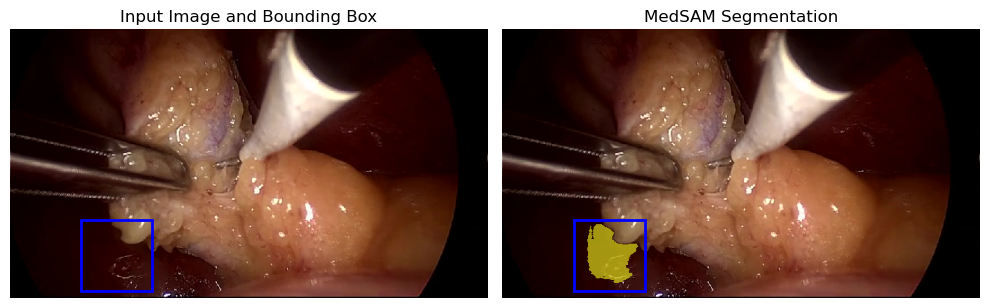

Segmentation complete! Mask shape: (360, 640)


In [5]:
# Set your parameters here
img_path = "/shared_data0/weiqiuy/real_drs/data/abdomen_exlib/images/cholec80_video20_006.png"  # Path to your image
box = [95, 255, 190, 350]  # Bounding box [x1, y1, x2, y2]
checkpoint_path = "/shared_data0/weiqiuy/github/MedSAM/work_dir/MedSAM/medsam_vit_b.pth"  # Path to MedSAM checkpoint
output_dir = "assets/"  # Where to save results
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Run inference
mask, original_img = run_medsam_inference(
    img_path=img_path,
    box=box,
    checkpoint_path=checkpoint_path,
    output_dir=output_dir,
    device=device,
    show_plot=True,
    save_result=True
)

print(f"Segmentation complete! Mask shape: {mask.shape}")

Loading MedSAM model from /shared_data0/weiqiuy/github/MedSAM/work_dir/MedSAM/medsam_vit_b.pth
Loading image from /shared_data0/weiqiuy/real_drs/data/abdomen_exlib/images/cholec80_video20_006.png
Computing image embedding...
Running MedSAM inference...
Segmentation saved to assets/seg_cholec80_video20_006.png


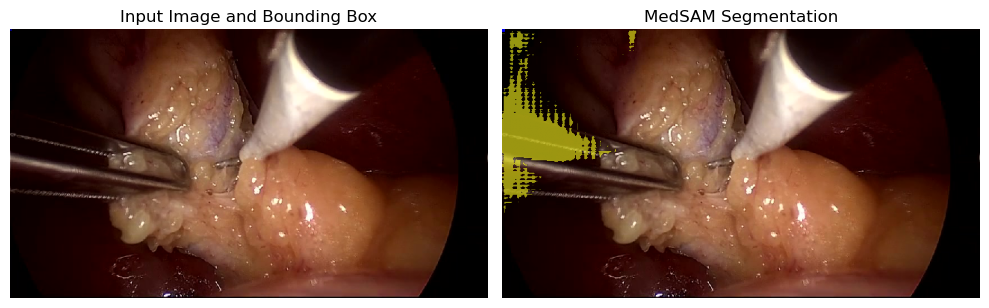

In [9]:
# Run inference
mask, original_img = run_medsam_inference(
    img_path=img_path,
    box=[0,0,-1,-1],
    checkpoint_path=checkpoint_path,
    output_dir=output_dir,
    device=device,
    show_plot=True,
    save_result=True
)

# MedSAM + PeskaVLP

In [1]:
# -*- coding: utf-8 -*-

"""
MedSAM inference example for Jupyter notebook usage
No argparse needed - all parameters are set as variables
"""

import numpy as np
import matplotlib.pyplot as plt
import os
import torch
from segment_anything import sam_model_registry
from skimage import io, transform
import torch.nn.functional as F
from scipy.ndimage import label, binary_dilation
from itertools import product
import cv2


# visualization functions
# source: https://github.com/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb
# change color to avoid red and green
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([251 / 255, 252 / 255, 30 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="blue", facecolor=(0, 0, 0, 0), lw=2)
    )


@torch.no_grad()
def medsam_inference(medsam_model, img_embed, box_1024, H, W):
    box_torch = torch.as_tensor(box_1024, dtype=torch.float, device=img_embed.device)
    if len(box_torch.shape) == 2:
        box_torch = box_torch[:, None, :]  # (B, 1, 4)

    sparse_embeddings, dense_embeddings = medsam_model.prompt_encoder(
        points=None,
        boxes=box_torch,
        masks=None,
    )
    low_res_logits, _ = medsam_model.mask_decoder(
        image_embeddings=img_embed,  # (B, 256, 64, 64)
        image_pe=medsam_model.prompt_encoder.get_dense_pe(),  # (1, 256, 64, 64)
        sparse_prompt_embeddings=sparse_embeddings,  # (B, 2, 256)
        dense_prompt_embeddings=dense_embeddings,  # (B, 256, 64, 64)
        multimask_output=False,
    )

    low_res_pred = torch.sigmoid(low_res_logits)  # (1, 1, 256, 256)

    low_res_pred = F.interpolate(
        low_res_pred,
        size=(H, W),
        mode="bilinear",
        align_corners=False,
    )  # (1, 1, gt.shape)
    low_res_pred = low_res_pred.squeeze().cpu().numpy()  # (256, 256)
    medsam_seg = (low_res_pred > 0.5).astype(np.uint8)
    return medsam_seg


def generate_sliding_windows(H, W, window_size=(128, 128), stride=(64, 64)):
    """
    Generate sliding window bounding boxes across the image.
    
    Args:
        H, W: Image height and width
        window_size: Size of sliding window (height, width)
        stride: Stride between windows (height, width)
    
    Returns:
        List of bounding boxes in [x1, y1, x2, y2] format
    """
    boxes = []
    window_h, window_w = window_size
    stride_h, stride_w = stride
    
    for y in range(0, H - window_h + 1, stride_h):
        for x in range(0, W - window_w + 1, stride_w):
            boxes.append([x, y, x + window_w, y + window_h])
    
    # Add edge boxes if image not fully covered
    if H % stride_h != 0:
        for x in range(0, W - window_w + 1, stride_w):
            boxes.append([x, H - window_h, x + window_w, H])
    if W % stride_w != 0:
        for y in range(0, H - window_h + 1, stride_h):
            boxes.append([W - window_w, y, W, y + window_h])
    if H % stride_h != 0 and W % stride_w != 0:
        boxes.append([W - window_w, H - window_h, W, H])
    
    return boxes


def generate_grid_boxes(H, W, grid_size=(4, 4), overlap=0.2):
    """
    Generate a grid of overlapping bounding boxes.
    
    Args:
        H, W: Image height and width
        grid_size: Number of boxes in (rows, cols)
        overlap: Overlap ratio between adjacent boxes
    
    Returns:
        List of bounding boxes in [x1, y1, x2, y2] format
    """
    boxes = []
    rows, cols = grid_size
    
    # Calculate box dimensions with overlap
    box_h = int(H / rows * (1 + overlap))
    box_w = int(W / cols * (1 + overlap))
    
    # Calculate stride
    stride_h = int((H - box_h) / (rows - 1)) if rows > 1 else 0
    stride_w = int((W - box_w) / (cols - 1)) if cols > 1 else 0
    
    for i in range(rows):
        for j in range(cols):
            y1 = min(i * stride_h, H - box_h)
            x1 = min(j * stride_w, W - box_w)
            y2 = min(y1 + box_h, H)
            x2 = min(x1 + box_w, W)
            boxes.append([x1, y1, x2, y2])
    
    return boxes


def merge_overlapping_masks(masks, iou_threshold=0.5):
    """
    Merge overlapping segmentation masks based on IoU threshold.
    
    Args:
        masks: List of binary masks
        iou_threshold: IoU threshold for merging
    
    Returns:
        List of merged masks
    """
    if len(masks) == 0:
        return []
    
    # Stack all masks
    mask_stack = np.stack(masks)
    n_masks = len(masks)
    
    # Track which masks have been merged
    merged = np.zeros(n_masks, dtype=bool)
    merged_masks = []
    
    for i in range(n_masks):
        if merged[i]:
            continue
            
        # Start with current mask
        combined_mask = masks[i].copy()
        merged[i] = True
        
        # Find overlapping masks
        for j in range(i + 1, n_masks):
            if merged[j]:
                continue
                
            # Calculate IoU
            intersection = np.logical_and(combined_mask, masks[j])
            union = np.logical_or(combined_mask, masks[j])
            iou = np.sum(intersection) / (np.sum(union) + 1e-8)
            
            # Merge if IoU exceeds threshold
            if iou > iou_threshold:
                combined_mask = np.logical_or(combined_mask, masks[j])
                merged[j] = True
        
        merged_masks.append(combined_mask.astype(np.uint8))
    
    return merged_masks


def extract_connected_components(mask, min_area=100):
    """
    Extract connected components from a binary mask.
    
    Args:
        mask: Binary mask
        min_area: Minimum area threshold for components
    
    Returns:
        List of component masks
    """
    labeled_mask, num_components = label(mask)
    components = []
    
    for i in range(1, num_components + 1):
        component_mask = (labeled_mask == i).astype(np.uint8)
        if np.sum(component_mask) >= min_area:
            components.append(component_mask)
    
    return components


def run_medsam_all_regions(
    img_path="assets/img_demo.png",
    checkpoint_path="work_dir/MedSAM/medsam_vit_b.pth",
    output_dir="assets/",
    device="cuda:0",
    method="grid",  # "grid", "sliding", or "both"
    grid_size=(4, 4),
    window_size=(256, 256),
    stride=(128, 128),
    overlap=0.3,
    merge_iou=0.5,
    min_area=500,
    confidence_threshold=0.5,
    show_plot=True,
    save_result=True
):
    """
    Run MedSAM inference to extract all possible regions from an image.
    
    Args:
        img_path: Path to input image
        checkpoint_path: Path to MedSAM checkpoint
        output_dir: Directory to save segmentation results
        device: Device to run inference on
        method: Method for generating boxes ("grid", "sliding", or "both")
        grid_size: Grid size for grid method
        window_size: Window size for sliding window method
        stride: Stride for sliding window method
        overlap: Overlap ratio for grid method
        merge_iou: IoU threshold for merging overlapping masks
        min_area: Minimum area for valid regions
        confidence_threshold: Confidence threshold for segmentation
        show_plot: Whether to display visualization
        save_result: Whether to save segmentation masks
    
    Returns:
        all_regions: List of segmentation masks for all detected regions
        img_3c: Original image (3-channel)
        boxes_used: List of bounding boxes that produced valid segments
    """
    
    # Load model
    print(f"Loading MedSAM model from {checkpoint_path}")
    medsam_model = sam_model_registry["vit_b"](checkpoint=checkpoint_path)
    medsam_model = medsam_model.to(device)
    medsam_model.eval()
    
    # Load and preprocess image
    print(f"Loading image from {img_path}")
    img_np = io.imread(img_path)
    if len(img_np.shape) == 2:
        img_3c = np.repeat(img_np[:, :, None], 3, axis=-1)
    else:
        img_3c = img_np
    H, W, _ = img_3c.shape
    
    # Generate bounding boxes
    print(f"Generating bounding boxes using {method} method...")
    boxes = []
    if method == "grid" or method == "both":
        grid_boxes = generate_grid_boxes(H, W, grid_size, overlap)
        boxes.extend(grid_boxes)
        print(f"  Generated {len(grid_boxes)} grid boxes")
    
    if method == "sliding" or method == "both":
        sliding_boxes = generate_sliding_windows(H, W, window_size, stride)
        boxes.extend(sliding_boxes)
        print(f"  Generated {len(sliding_boxes)} sliding window boxes")
    
    # Remove duplicate boxes
    unique_boxes = []
    for box in boxes:
        if box not in unique_boxes:
            unique_boxes.append(box)
    boxes = unique_boxes
    print(f"Total unique boxes: {len(boxes)}")
    
    # Image preprocessing for model input
    img_1024 = transform.resize(
        img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True
    ).astype(np.uint8)
    img_1024 = (img_1024 - img_1024.min()) / np.clip(
        img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
    )
    
    # Convert to tensor
    img_1024_tensor = (
        torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)
    )
    
    # Get image embedding (compute once for all boxes)
    print("Computing image embedding...")
    with torch.no_grad():
        image_embedding = medsam_model.image_encoder(img_1024_tensor)
    
    # Process all boxes
    print(f"Processing {len(boxes)} bounding boxes...")
    all_masks = []
    boxes_used = []
    
    for i, box in enumerate(boxes):
        if (i + 1) % 10 == 0:
            print(f"  Processing box {i + 1}/{len(boxes)}")
        
        # Convert box to 1024x1024 scale
        box_np = np.array([box])
        box_1024 = box_np / np.array([W, H, W, H]) * 1024
        
        # Run inference
        try:
            medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, H, W)
            
            # Check if mask has significant content
            if np.sum(medsam_seg) > min_area:
                all_masks.append(medsam_seg)
                boxes_used.append(box)
        except Exception as e:
            print(f"  Warning: Failed to process box {i}: {e}")
            continue
    
    print(f"Generated {len(all_masks)} valid masks")
    
    # Merge overlapping masks
    print("Merging overlapping masks...")
    merged_masks = merge_overlapping_masks(all_masks, merge_iou)
    print(f"After merging: {len(merged_masks)} masks")
    
    # Extract connected components from merged masks
    print("Extracting connected components...")
    all_regions = []
    for mask in merged_masks:
        components = extract_connected_components(mask, min_area)
        all_regions.extend(components)
    print(f"Final regions: {len(all_regions)}")
    
    # Save results if requested
    if save_result:
        os.makedirs(output_dir, exist_ok=True)
        
        # Save individual regions
        regions_dir = os.path.join(output_dir, "regions")
        os.makedirs(regions_dir, exist_ok=True)
        
        for i, region in enumerate(all_regions):
            region_path = os.path.join(regions_dir, f"region_{i:03d}.png")
            io.imsave(region_path, region * 255, check_contrast=False)
        
        # Save combined mask
        if all_regions:
            combined_mask = np.zeros_like(all_regions[0])
            for region in all_regions:
                combined_mask = np.logical_or(combined_mask, region)
            combined_path = os.path.join(output_dir, "all_regions_combined.png")
            io.imsave(combined_path, combined_mask.astype(np.uint8) * 255, check_contrast=False)
            print(f"Saved {len(all_regions)} regions to {regions_dir}")
            print(f"Saved combined mask to {combined_path}")
    
    # Visualize results if requested
    if show_plot and all_regions:
        # Create color map for different regions
        colors = plt.cm.tab20(np.linspace(0, 1, len(all_regions)))
        
        fig, axes = plt.subplots(2, 2, figsize=(15, 15))
        
        # Original image with boxes
        axes[0, 0].imshow(img_3c)
        for box in boxes_used[:20]:  # Show first 20 boxes to avoid clutter
            show_box(box, axes[0, 0])
        axes[0, 0].set_title(f"Input Image with Sample Boxes ({len(boxes_used)} total)")
        axes[0, 0].axis('off')
        
        # All regions with different colors
        axes[0, 1].imshow(img_3c)
        for i, region in enumerate(all_regions):
            if np.any(region):
                masked = np.ma.masked_where(region == 0, region)
                axes[0, 1].imshow(masked, alpha=0.5, cmap=plt.cm.colors.ListedColormap([colors[i]]))
        axes[0, 1].set_title(f"All {len(all_regions)} Detected Regions")
        axes[0, 1].axis('off')
        
        # Individual regions grid
        n_show = min(len(all_regions), 4)
        for i in range(n_show):
            ax = axes[1, i % 2]
            if i < 2:
                ax.clear()
            ax.imshow(img_3c, alpha=0.3)
            ax.imshow(all_regions[i], alpha=0.7, cmap='jet')
            ax.set_title(f"Region {i}")
            ax.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    return all_regions, img_3c, boxes_used


def run_medsam_inference(
    img_path="assets/img_demo.png",
    box=[95, 255, 190, 350],  # [x1, y1, x2, y2] format
    checkpoint_path="work_dir/MedSAM/medsam_vit_b.pth",
    output_dir="assets/",
    device="cuda:0",
    show_plot=True,
    save_result=True
):
    """
    Run MedSAM inference on a single image with a bounding box.
    
    Args:
        img_path: Path to input image
        box: Bounding box coordinates [x1, y1, x2, y2]
        checkpoint_path: Path to MedSAM checkpoint
        output_dir: Directory to save segmentation results
        device: Device to run inference on
        show_plot: Whether to display visualization
        save_result: Whether to save segmentation mask
    
    Returns:
        medsam_seg: Binary segmentation mask
        img_3c: Original image (3-channel)
    """
    
    # Load model
    print(f"Loading MedSAM model from {checkpoint_path}")
    medsam_model = sam_model_registry["vit_b"](checkpoint=checkpoint_path)
    medsam_model = medsam_model.to(device)
    medsam_model.eval()
    
    # Load and preprocess image
    print(f"Loading image from {img_path}")
    img_np = io.imread(img_path)
    if len(img_np.shape) == 2:
        img_3c = np.repeat(img_np[:, :, None], 3, axis=-1)
    else:
        img_3c = img_np
    H, W, _ = img_3c.shape
    
    # Image preprocessing for model input
    img_1024 = transform.resize(
        img_3c, (1024, 1024), order=3, preserve_range=True, anti_aliasing=True
    ).astype(np.uint8)
    img_1024 = (img_1024 - img_1024.min()) / np.clip(
        img_1024.max() - img_1024.min(), a_min=1e-8, a_max=None
    )  # normalize to [0, 1], (H, W, 3)
    
    # Convert to tensor
    img_1024_tensor = (
        torch.tensor(img_1024).float().permute(2, 0, 1).unsqueeze(0).to(device)
    )
    
    # Convert box to 1024x1024 scale
    box_np = np.array([box])
    box_1024 = box_np / np.array([W, H, W, H]) * 1024
    
    # Get image embedding
    print("Computing image embedding...")
    with torch.no_grad():
        image_embedding = medsam_model.image_encoder(img_1024_tensor)  # (1, 256, 64, 64)
    
    # Run inference
    print("Running MedSAM inference...")
    medsam_seg = medsam_inference(medsam_model, image_embedding, box_1024, H, W)
    
    # Save result if requested
    if save_result:
        os.makedirs(output_dir, exist_ok=True)
        output_path = os.path.join(output_dir, "seg_" + os.path.basename(img_path))
        io.imsave(output_path, medsam_seg, check_contrast=False)
        print(f"Segmentation saved to {output_path}")
    
    # Visualize results if requested
    if show_plot:
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(img_3c)
        show_box(box_np[0], ax[0])
        ax[0].set_title("Input Image and Bounding Box")
        ax[0].axis('off')
        
        ax[1].imshow(img_3c)
        show_mask(medsam_seg, ax[1])
        show_box(box_np[0], ax[1])
        ax[1].set_title("MedSAM Segmentation")
        ax[1].axis('off')
        
        plt.tight_layout()
        plt.show()
    
    return medsam_seg, img_3c


Example 1: Single bounding box segmentation
Loading MedSAM model from /shared_data0/weiqiuy/github/MedSAM/work_dir/MedSAM/medsam_vit_b.pth
Loading image from /shared_data0/weiqiuy/real_drs/data/abdomen_exlib/images/cholec80_video20_006.png
Computing image embedding...
Running MedSAM inference...
Segmentation saved to assets/seg_cholec80_video20_006.png


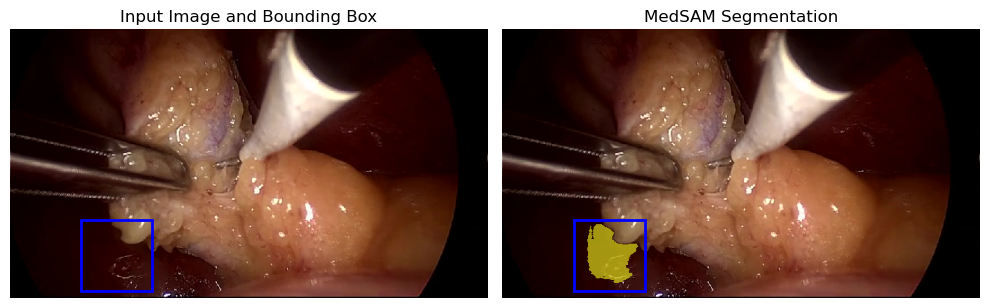

Segmentation complete! Mask shape: (360, 640)

Example 2: Extract all regions with grid method
Loading MedSAM model from /shared_data0/weiqiuy/github/MedSAM/work_dir/MedSAM/medsam_vit_b.pth
Loading image from /shared_data0/weiqiuy/real_drs/data/abdomen_exlib/images/cholec80_video20_006.png
Generating bounding boxes using grid method...
  Generated 9 grid boxes
Total unique boxes: 9
Computing image embedding...
Processing 9 bounding boxes...
Generated 9 valid masks
Merging overlapping masks...
After merging: 9 masks
Extracting connected components...
Final regions: 10
Saved 10 regions to assets/grid_regions/regions
Saved combined mask to assets/grid_regions/all_regions_combined.png


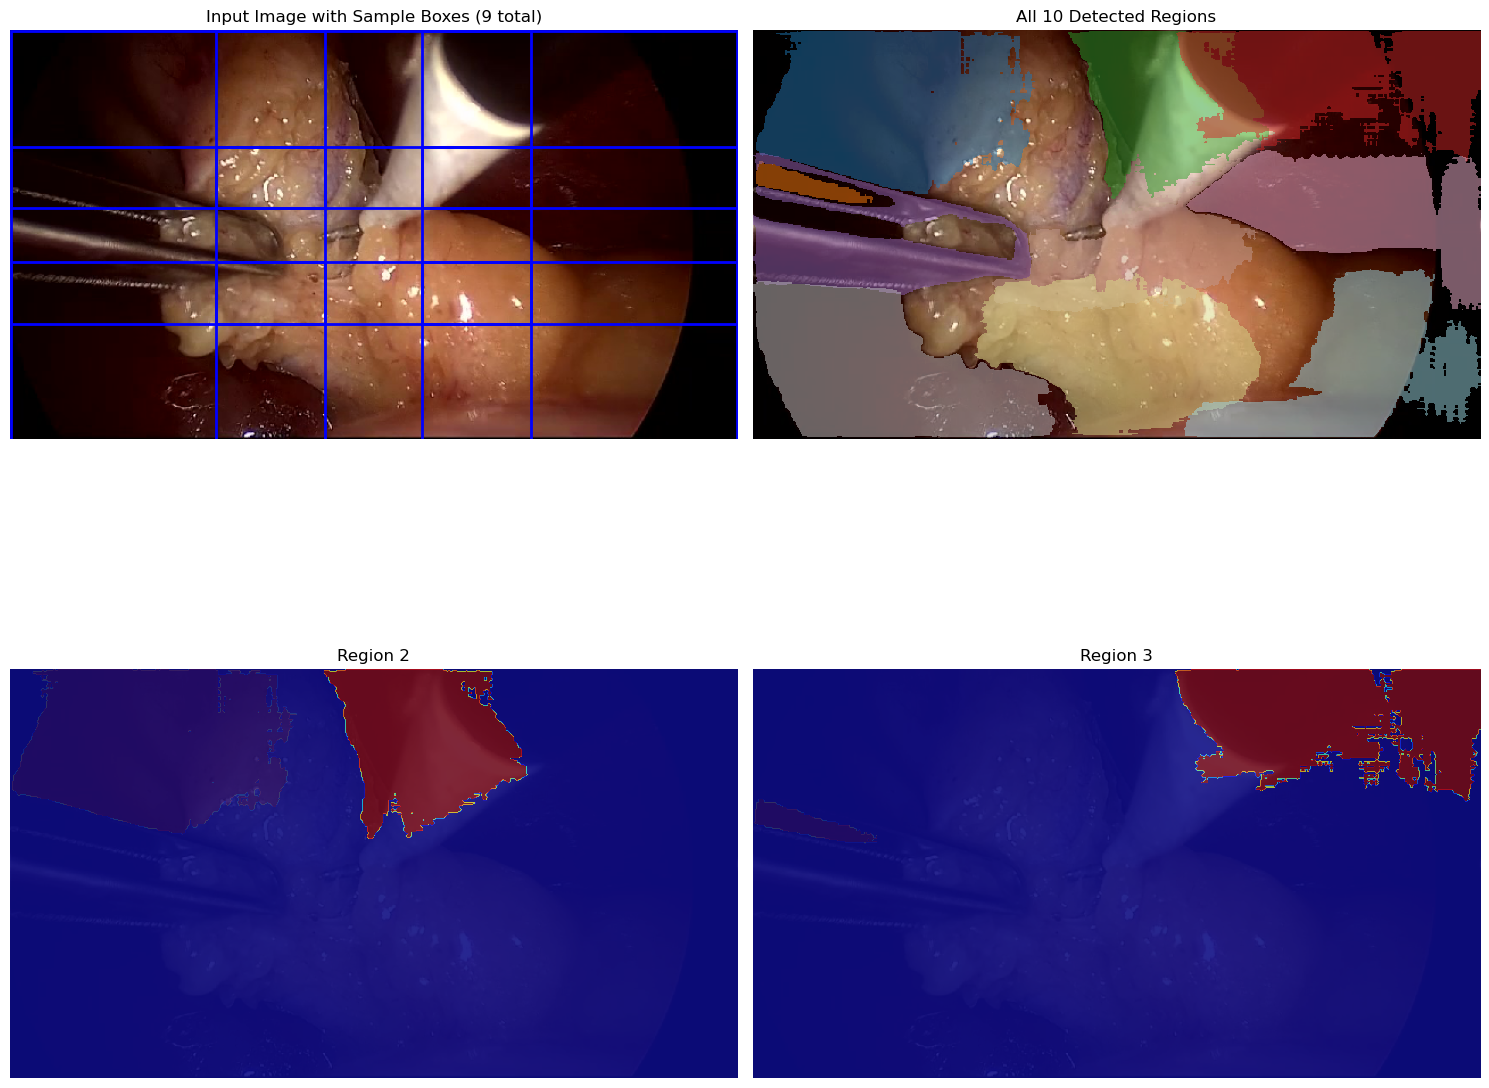

Found 10 regions using grid method

Example 3: Extract all regions with sliding window
Loading MedSAM model from /shared_data0/weiqiuy/github/MedSAM/work_dir/MedSAM/medsam_vit_b.pth
Loading image from /shared_data0/weiqiuy/real_drs/data/abdomen_exlib/images/cholec80_video20_006.png
Generating bounding boxes using sliding method...
  Generated 8 sliding window boxes
Total unique boxes: 8
Computing image embedding...
Processing 8 bounding boxes...
Generated 8 valid masks
Merging overlapping masks...
After merging: 8 masks
Extracting connected components...
Final regions: 12
Saved 12 regions to assets/sliding_regions/regions
Saved combined mask to assets/sliding_regions/all_regions_combined.png


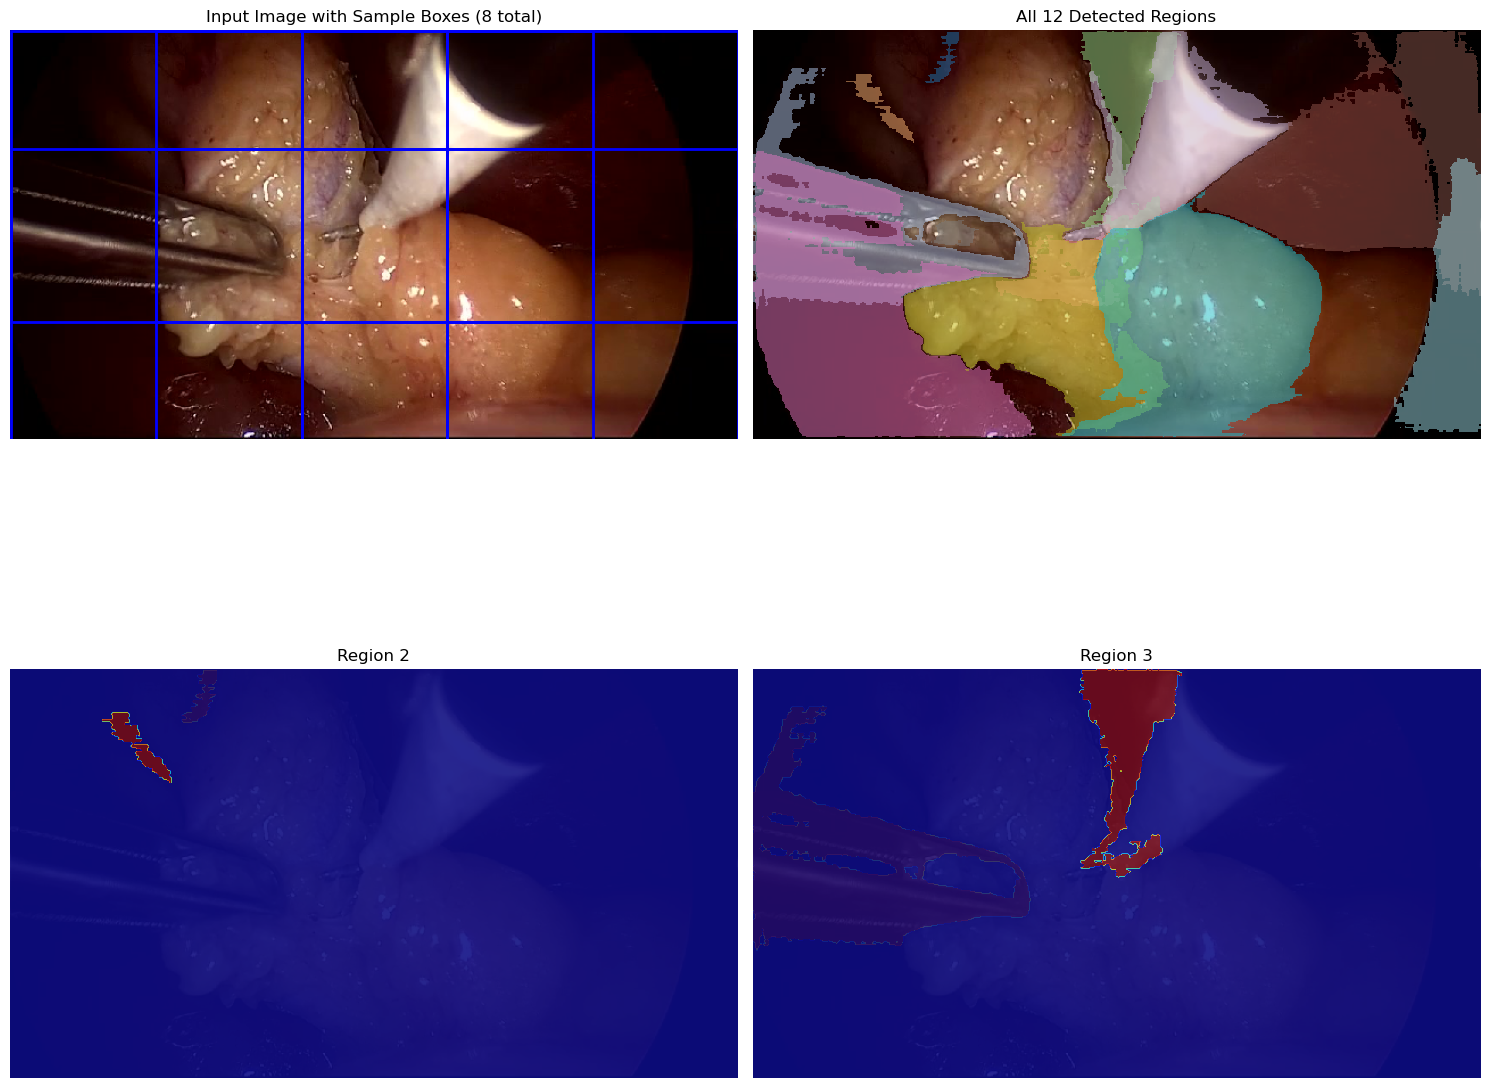

Found 12 regions using sliding window

Example 4: Extract all regions with both methods
Loading MedSAM model from /shared_data0/weiqiuy/github/MedSAM/work_dir/MedSAM/medsam_vit_b.pth
Loading image from /shared_data0/weiqiuy/real_drs/data/abdomen_exlib/images/cholec80_video20_006.png
Generating bounding boxes using both method...
  Generated 16 grid boxes
  Generated 18 sliding window boxes
Total unique boxes: 34
Computing image embedding...
Processing 34 bounding boxes...
  Processing box 10/34
  Processing box 20/34
  Processing box 30/34
Generated 34 valid masks
Merging overlapping masks...
After merging: 28 masks
Extracting connected components...
Final regions: 34
Saved 34 regions to assets/combined_regions/regions
Saved combined mask to assets/combined_regions/all_regions_combined.png


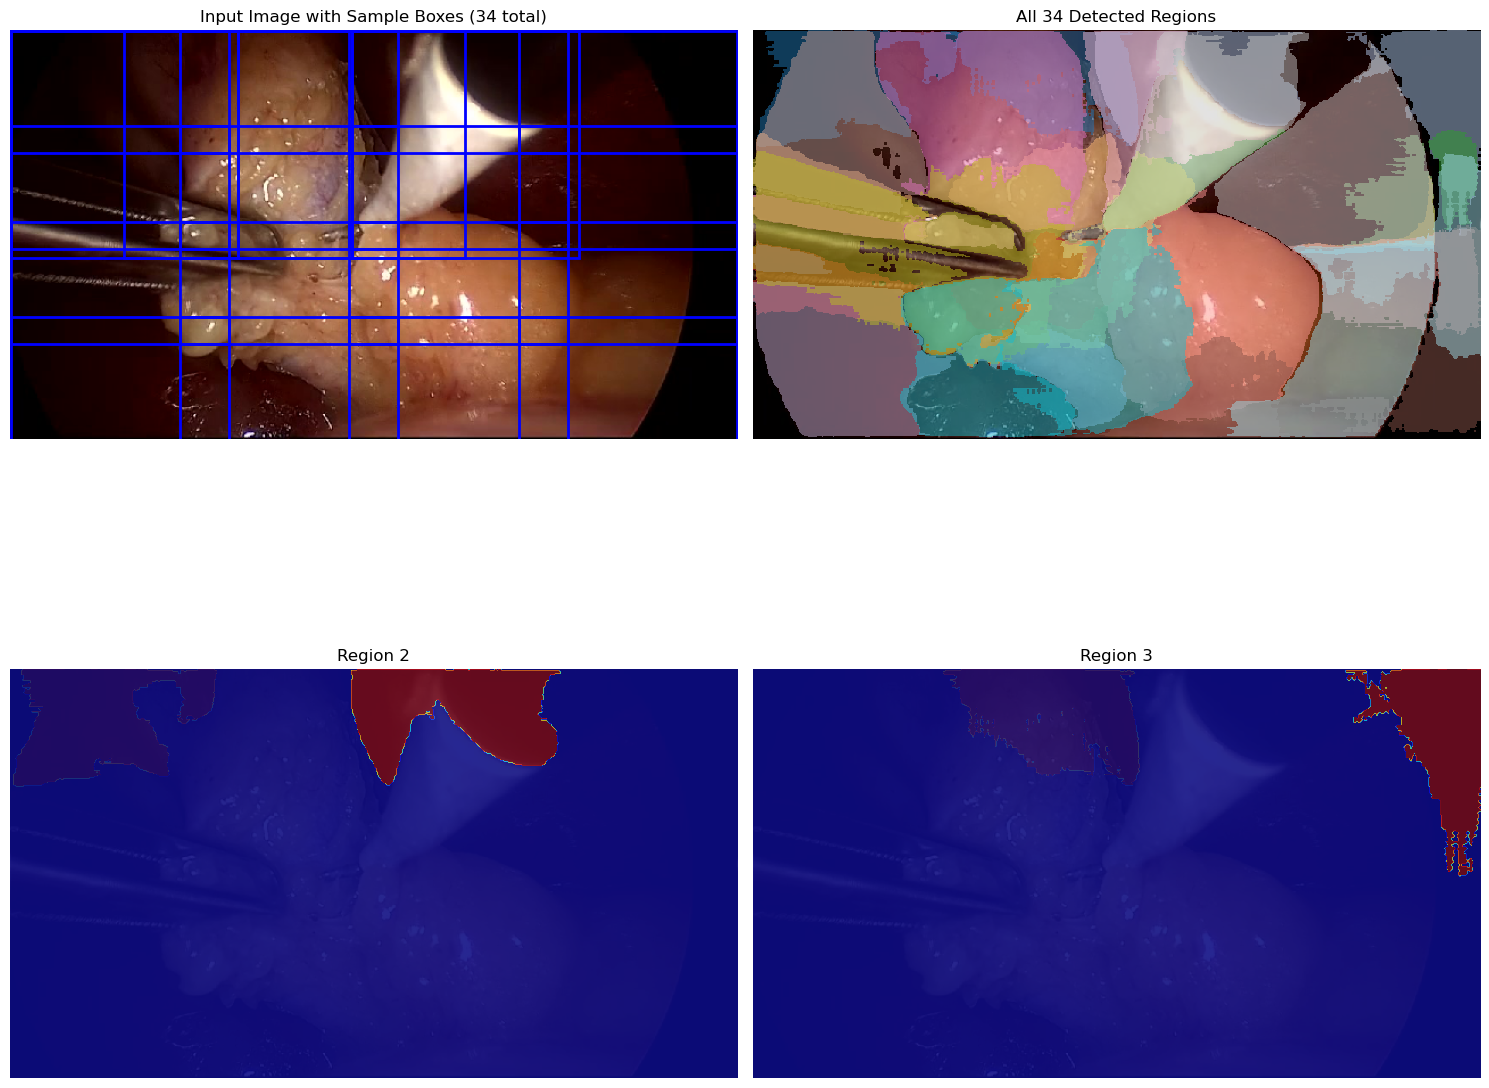

Found 34 regions using combined methods

Summary
Grid method: 10 regions from 9 boxes
Sliding window: 12 regions from 8 boxes
Combined: 34 regions from 34 boxes


In [4]:
# Set your parameters here
img_path = "/shared_data0/weiqiuy/real_drs/data/abdomen_exlib/images/cholec80_video20_006.png"  # Path to your image

# img_path = "assets/img_demo.png"  # Path to your image
checkpoint_path = "/shared_data0/weiqiuy/github/MedSAM/work_dir/MedSAM/medsam_vit_b.pth"  # Path to MedSAM checkpoint
output_dir = "assets/"  # Where to save results
device = "cuda:0" if torch.cuda.is_available() else "cpu"

# Example 1: Single box inference (original functionality)
print("=" * 60)
print("Example 1: Single bounding box segmentation")
print("=" * 60)
box = [95, 255, 190, 350]  # Bounding box [x1, y1, x2, y2]
mask, original_img = run_medsam_inference(
    img_path=img_path,
    box=box,
    checkpoint_path=checkpoint_path,
    output_dir=output_dir,
    device=device,
    show_plot=True,
    save_result=True
)
print(f"Segmentation complete! Mask shape: {mask.shape}")

# Example 2: Extract all regions using grid method
print("\n" + "=" * 60)
print("Example 2: Extract all regions with grid method")
print("=" * 60)
all_regions_grid, img, boxes_grid = run_medsam_all_regions(
    img_path=img_path,
    checkpoint_path=checkpoint_path,
    output_dir=os.path.join(output_dir, "grid_regions"),
    device=device,
    method="grid",
    grid_size=(3, 3),  # 3x3 grid
    overlap=0.3,  # 30% overlap between adjacent boxes
    merge_iou=0.5,  # Merge masks with IoU > 0.5
    min_area=500,  # Minimum region size
    show_plot=True,
    save_result=True
)
print(f"Found {len(all_regions_grid)} regions using grid method")

# Example 3: Extract all regions using sliding window
print("\n" + "=" * 60)
print("Example 3: Extract all regions with sliding window")
print("=" * 60)
all_regions_sliding, img, boxes_sliding = run_medsam_all_regions(
    img_path=img_path,
    checkpoint_path=checkpoint_path,
    output_dir=os.path.join(output_dir, "sliding_regions"),
    device=device,
    method="sliding",
    window_size=(256, 256),  # Window size
    stride=(128, 128),  # 50% overlap (stride = window_size/2)
    merge_iou=0.5,
    min_area=500,
    show_plot=True,
    save_result=True
)
print(f"Found {len(all_regions_sliding)} regions using sliding window")

# Example 4: Extract all regions using both methods combined
print("\n" + "=" * 60)
print("Example 4: Extract all regions with both methods")
print("=" * 60)
all_regions_both, img, boxes_both = run_medsam_all_regions(
    img_path=img_path,
    checkpoint_path=checkpoint_path,
    output_dir=os.path.join(output_dir, "combined_regions"),
    device=device,
    method="both",
    grid_size=(4, 4),
    window_size=(200, 200),
    stride=(100, 100),
    overlap=0.2,
    merge_iou=0.4,  # Lower threshold for more aggressive merging
    min_area=300,
    show_plot=True,
    save_result=True
)
print(f"Found {len(all_regions_both)} regions using combined methods")

# Summary statistics
print("\n" + "=" * 60)
print("Summary")
print("=" * 60)
print(f"Grid method: {len(all_regions_grid)} regions from {len(boxes_grid)} boxes")
print(f"Sliding window: {len(all_regions_sliding)} regions from {len(boxes_sliding)} boxes")
print(f"Combined: {len(all_regions_both)} regions from {len(boxes_both)} boxes")